# Documentation of Intro to Machine Learning Project.

In [ ]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit

### Task 1: Select what features you'll use.
features_list = ['poi','salary'] 

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers

### Task 3: Create new feature(s)

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [3]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit

## Basic Data Exploration

In [4]:
#Show the most important characteristics of the dataset
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
import pandas as pd
df = pd.DataFrame(data_dict).T

#get total number of data points, total number of features
num_datapoints = df.shape[0]
num_features = df.shape[1] - 1 #I subtracted 1 because POI ins't feature, it is label(class).
print "Total number of data points:", num_datapoints
print "Total number of features:", num_features
print "" #insert blank line

#show the allocation across classes(POI/non-POI)
poi_allocation = df.poi.value_counts()
print "The allocation across classes(POI/non-POI):"
print poi_allocation
print "The proportion of POI:", round(poi_allocation.loc[True] / float(df.poi.count()) * 100, 2), "%"
print "" #insert blank line

#show how many NaNs in each feature
num_NaN_in_each_feature = (df == 'NaN').sum()
print "The number of NaNs in each feature:"
print num_NaN_in_each_feature.sort_values(ascending = False)

Total number of data points: 146
Total number of features: 20

The allocation across classes(POI/non-POI):
False    128
True      18
Name: poi, dtype: int64
The proportion of POI: 12.33 %

The number of NaNs in each feature:
loan_advances                142
director_fees                129
restricted_stock_deferred    128
deferral_payments            107
deferred_income               97
long_term_incentive           80
bonus                         64
from_this_person_to_poi       60
from_poi_to_this_person       60
from_messages                 60
shared_receipt_with_poi       60
to_messages                   60
other                         53
expenses                      51
salary                        51
exercised_stock_options       44
restricted_stock              36
email_address                 35
total_payments                21
total_stock_value             20
poi                            0
dtype: int64


- The data has skewed classses. Therefore it would be better to use precision and recall as evaluation metrics rather than accuracy. 

- When considering the number of NaN values of each feature, it would be better to use features like total_stock_value and total_payments rather than loan_advances, director_fees and restricted_stock_deferred.

## 1. Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?

- The goal of this project is to build a person of interest identifier based on financial and email data made public as a result of the Enron scandal. And machine learning can be useful in this case because it can detect hidden patterns in the data using its features better than humans.

- In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. The key people of the scancal were Jeff Skilling, Kenneth Lay and Andrew Fastow. Jeff Skilling was the chairman of the Enron board of directors. Kenneth Lay was the CEO of Enron during most of the time that fraud was being perpetrated. Andrew Fastow was CFO (chief financial officer) of Enron during most of the time that fraud was going on. They were sentenced to imprisonment. We can know whether the identifier can detect POIs well by seeing that they were detected.

In [9]:
#See if there is any outlier.
#I'm going to see the distribution of total_stock_value and total_payments.
#I chose them because they have least NaNs.
def scatter_plot_for_two_features(data_dict, label, feature1, feature2):
    '''
    This function is to draw scatter plot of 2 features.
    
    Inputs: 1) data_dict - data typed dictionary.  
            2) label - labels of classes of points. There needs to be 2 lables in this function.
            3, 4) feature1, feature2 - features of the data whose distribution or relation between them you want to see 
            
    Output: scatter plot of 2 features colored by each label.
    '''
    features_list = [label, feature1, feature2]

    data = featureFormat(data_dict, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)

    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    for i in range(len(labels)):
        point_feature1 = features[i][0]
        point_feature2 = features[i][1]

        if labels[i] == True:
            c = 'red'
        else:
            c = 'blue'
        plt.scatter(point_feature1, point_feature2, c = c)
        
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    
    red_patch = mpatches.Patch(color = 'red', label = 'POI')
    blue_patch = mpatches.Patch(color = 'blue', label = 'Non-POI')
    plt.legend(handles = [red_patch, blue_patch])
    plt.title('Enron data scatter plot')

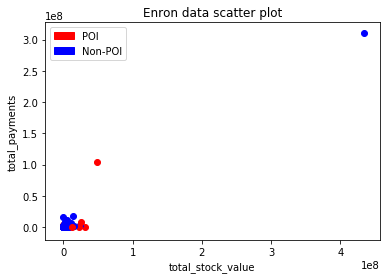

In [10]:
#See the scatter plot of total_stock_value and total_payments.
scatter_plot_for_two_features(data_dict, 'poi', 'total_stock_value', 'total_payments')

There are 2 outliers. I need to check who they are.

In [21]:
#I'm going to filter outliers by total_payments.
for data_point in data_dict:
    total_payment = data_dict[data_point]['total_payments']
    if total_payment != 'NaN':
        if total_payment >= 10**8:
            print 'Name:', data_point
            print 'Total_payments:', total_payment
            print '' #insert blank line.

Name: LAY KENNETH L
Total_payments: 103559793

Name: TOTAL
Total_payments: 309886585



Kenneth Lay's information need to remain because it is freak but meaningful event. 
But TOTAL needs to be deleted because it isn't a person's data.

In [22]:
#Delete TOTAL from data_dict using pop function.

In [ ]:
using condition find the name of the outlier.

dict.pop(name, 0) before featureFormat() to remove outlier.

## 2. What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.

## 3. What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms? 

## 4. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier). 

## 5. What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?

## 6. Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.